In [ ]:
import sys

# Setup

In [ ]:
# To add your own Drive Run this cell.
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Please append your own directory after ‘/content/drive/My Drive/'
# where you have nutil.py and adult_subsample.csv
### ========== TODO : START ========== ###
sys.path += ['/content/drive/My Drive/cm146/ps1']
sys.path += ['/content/drive/']

### ========== TODO : END ========== ###


In [ ]:
from nutil import *

In [ ]:
# Use only the provided packages!
import math
import csv

from collections import Counter

from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedShuffleSplit, train_test_split
import numpy as np
import warnings
warnings.filterwarnings('ignore', category=np.VisibleDeprecationWarning)

# Models

In [ ]:
######################################################################
# Immutatble classes
######################################################################

class Classifier(object) :
    """
    Classifier interface.
    """

    def fit(self, X, y):
        raise NotImplementedError()

    def predict(self, X):
        raise NotImplementedError()


class MajorityVoteClassifier(Classifier) :

    def __init__(self) :
        """
        A classifier that always predicts the majority class.

        Attributes
        --------------------
            prediction_ -- majority class
        """
        self.prediction_ = None

    def fit(self, X, y) :
        """
        Build a majority vote classifier from the training set (X, y).

        Parameters
        --------------------
            X    -- numpy array of shape (n,d), samples
            y    -- numpy array of shape (n,), target classes

        Returns
        --------------------
            self -- an instance of self
        """
        majority_val = Counter(y).most_common(1)[0][0]
        self.prediction_ = majority_val
        return self

    def predict(self, X) :
        """
        Predict class values.

        Parameters
        --------------------
            X    -- numpy array of shape (n,d), samples

        Returns
        --------------------
            y    -- numpy array of shape (n,), predicted classes
        """
        if self.prediction_ is None :
            raise Exception("Classifier not initialized. Perform a fit first.")

        n,d = X.shape
        y = [self.prediction_] * n
        return y



In [ ]:
######################################################################
# Mutatble classes
######################################################################

class RandomClassifier(Classifier) :

    def __init__(self) :
        """
        A classifier that predicts according to the distribution of the classes.

        Attributes
        --------------------
            probabilities_ -- class distribution dict (key = class, val = probability of class)
        """
        self.probabilities_ = None

    def fit(self, X, y) :
        """
        Build a random classifier from the training set (X, y).

        Parameters
        --------------------
            X    -- numpy array of shape (n,d), samples
            y    -- numpy array of shape (n,), target classes

        Returns
        --------------------
            self -- an instance of self
        """

        ### ========== TODO : START ========== ###
        # part b: set self.probabilities_ according to the training set
        unique_classes, counts = np.unique(y, return_counts=True)
        self.probabilities_ = {cls: count / len(y) for cls, count in zip(unique_classes, counts)}


        ### ========== TODO : END ========== ###

        return self

    def predict(self, X, seed=1234) :
        """
        Predict class values.

        Parameters
        --------------------
            X    -- numpy array of shape (n,d), samples
            seed -- integer, random seed

        Returns
        --------------------
            y    -- numpy array of shape (n,), predicted classes
        """
        if self.probabilities_ is None :
            raise Exception("Classifier not initialized. Perform a fit first.")
        np.random.seed(seed)

        ### ========== TODO : START ========== ###
        # part b: predict the class for each test example
        # hint: use np.random.choice (be careful of the parameters)
        classes = list(self.probabilities_.keys())
        probabilities = list(self.probabilities_.values())
        y = np.random.choice(classes, size = len(X), p=probabilities)
        ### ========== TODO : END ========== ###

        return y


# Auxiliary functions

In [ ]:
######################################################################
# Immutatble functions
######################################################################

def plot_histograms(X, y, Xnames, yname) :
    n,d = X.shape  # n = number of examples, d =  number of features
    fig = plt.figure(figsize=(20,15))
    ncol = 3
    nrow = d // ncol + 1
    for i in range(d) :
        fig.add_subplot (nrow,ncol,i+1)
        data, bins, align, labels = plot_histogram(X[:,i], y, Xname=Xnames[i], yname=yname, show = False)
        n, bins, patches = plt.hist(data, bins=bins, align=align, alpha=0.5, label=labels)
        plt.xlabel(Xnames[i])
        plt.ylabel('Frequency')
        plt.legend() #plt.legend(loc='upper left')

    plt.savefig ('histograms.pdf')


def plot_histogram(X, y, Xname, yname, show = True) :
    """
    Plots histogram of values in X grouped by y.

    Parameters
    --------------------
        X     -- numpy array of shape (n,d), feature values
        y     -- numpy array of shape (n,), target classes
        Xname -- string, name of feature
        yname -- string, name of target
    """

    # set up data for plotting
    targets = sorted(set(y))
    data = []; labels = []
    for target in targets :
        features = [X[i] for i in range(len(y)) if y[i] == target]
        data.append(features)
        labels.append('%s = %s' % (yname, target))

    # set up histogram bins
    features = set(X)
    nfeatures = len(features)
    test_range = list(range(int(math.floor(min(features))), int(math.ceil(max(features)))+1))
    if nfeatures < 10 and sorted(features) == test_range:
        bins = test_range + [test_range[-1] + 1] # add last bin
        align = 'left'
    else :
        bins = 10
        align = 'mid'

    # plot
    if show == True:
        plt.figure()
        n, bins, patches = plt.hist(data, bins=bins, align=align, alpha=0.5, label=labels)
        plt.xlabel(Xname)
        plt.ylabel('Frequency')
        plt.legend() #plt.legend(loc='upper left')
        plt.show()

    return data, bins, align, labels

In [ ]:
######################################################################
# Mutatble functions
######################################################################

def error(clf, X, y, ntrials=100, test_size=0.2) :
    """
    Computes the classifier error over a random split of the data,
    averaged over ntrials runs.

    Parameters
    --------------------
        clf         -- classifier
        X           -- numpy array of shape (n,d), features values
        y           -- numpy array of shape (n,), target classes
        ntrials     -- integer, number of trials

    Returns
    --------------------
        train_error -- float, training error
        test_error  -- float, test error
        f1_score    -- float, test "micro" averaged f1 score
    """

    ### ========== TODO : START ========== ###
    # compute cross-validation error using StratifiedShuffleSplit over ntrials
    sss = StratifiedShuffleSplit(n_splits=ntrials, test_size=test_size, random_state=42)

    train_errors = []
    test_errors = []
    f1_scores = []

    for train_idx, test_idx in sss.split(X, y):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        # Train classifier
        clf.fit(X_train, y_train)

        # Predictions
        y_train_pred = clf.predict(X_train)
        y_test_pred = clf.predict(X_test)

        # Compute errors
        train_error = 1-metrics.accuracy_score(y_train,y_train_pred)  # Error rate = 1 - accuracy
        test_error = 1-metrics.accuracy_score(y_test, y_test_pred)

        # Compute F1 score
        f1 = metrics.f1_score(y_test, y_test_pred, average='micro')


        # Store results
        train_errors.append(train_error)
        test_errors.append(test_error)
        f1_scores.append(f1)

    avg_train_error = np.mean(train_errors)
    avg_test_error = np.mean(test_errors)
    avg_f1_score = np.mean(f1_scores)
    ### ========== TODO : END ========== ###

    return avg_train_error, avg_test_error, avg_f1_score

In [ ]:
######################################################################
# Immutatble functions
######################################################################


def write_predictions(y_pred, filename, yname=None) :
    """Write out predictions to csv file."""
    out = open(filename, 'wb')
    f = csv.writer(out)
    if yname :
        f.writerow([yname])
    f.writerows(list(zip(y_pred)))
    out.close()

# Evaluation

Plotting...


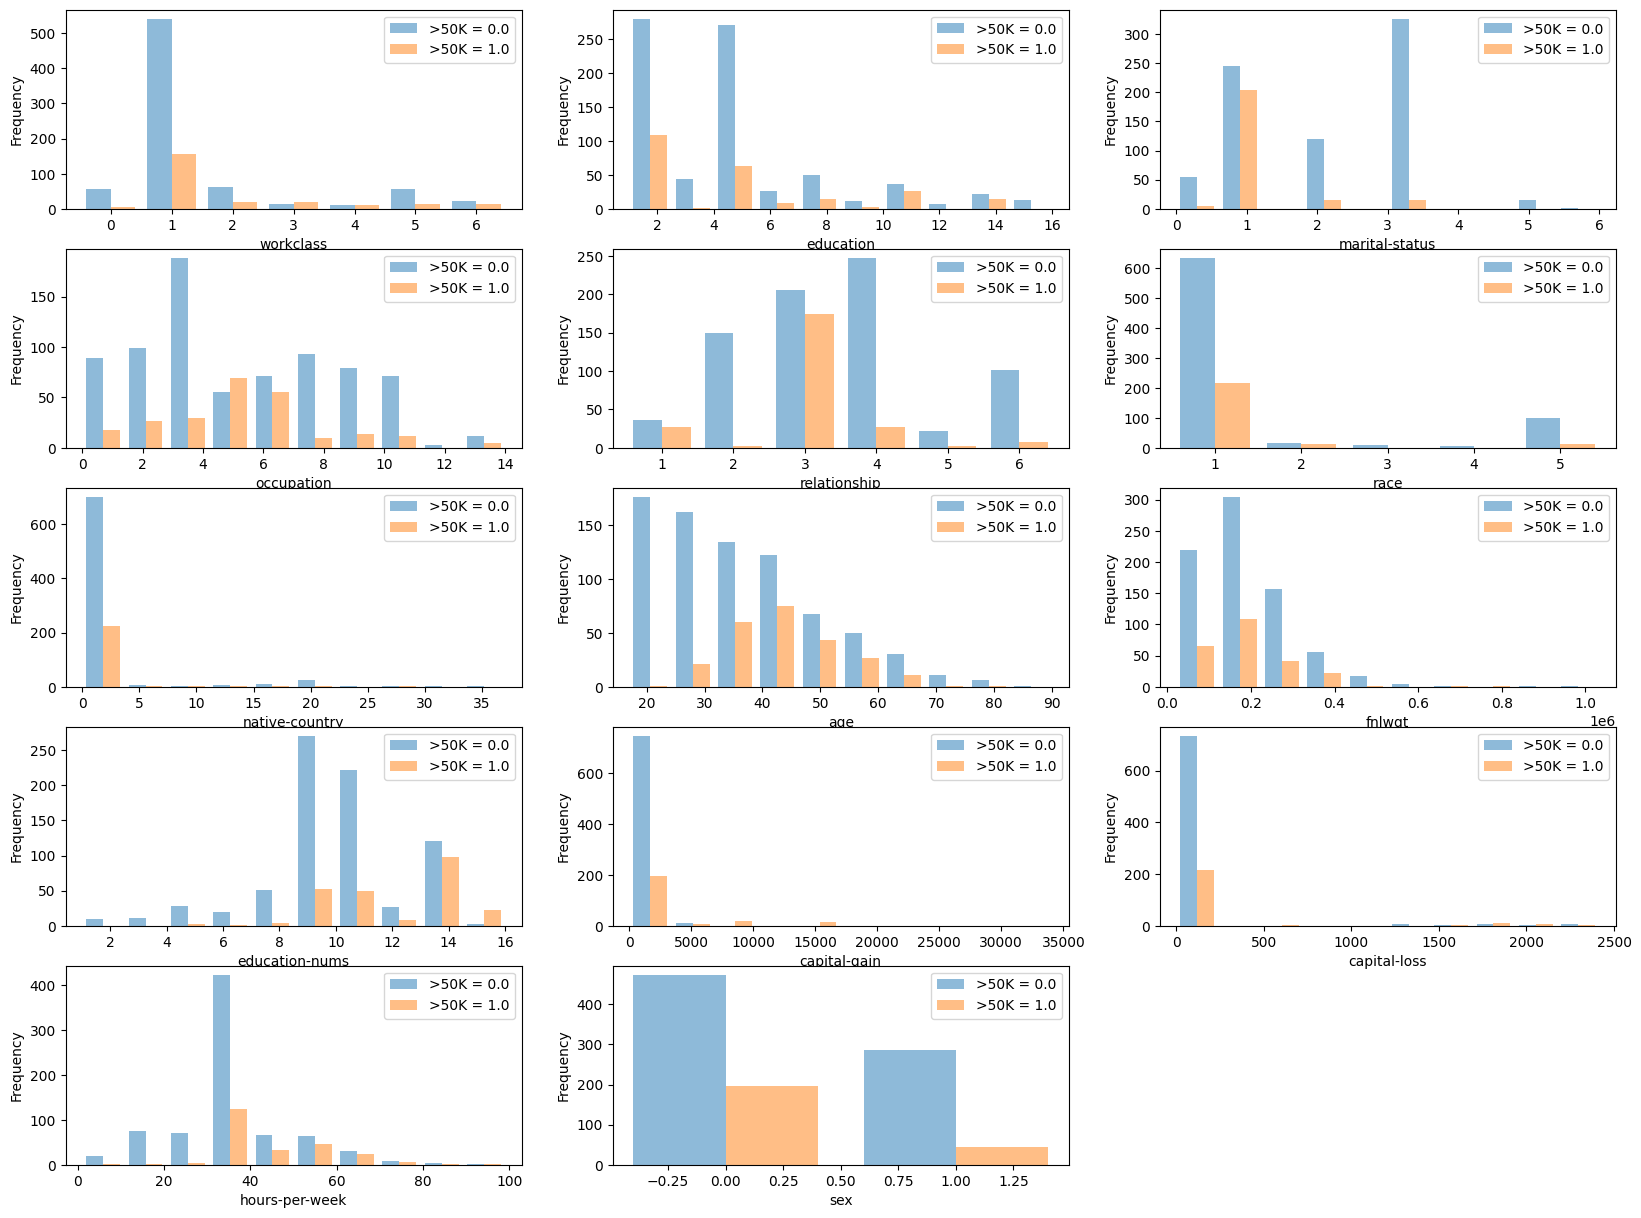

Classifying using Majority Vote...
	-- training error: 0.240
Classifying using Random...
	-- training error: 0.374
Classifying using Decision Tree...
	-- training error: 0.000
Classifying using k-Nearest Neighbors...
Training error for KNN k = 3 : 0.11399999999999999
Training error for KNN k = 5 : 0.129
Training error for KNN k = 7 : 0.15200000000000002
Investigating various classifiers...
Evaluating Majority Vote...
	-- Training Error: 0.240
	-- Test Error: 0.240
	-- F1 Score: 0.760
Evaluating Random...
	-- Training Error: 0.375
	-- Test Error: 0.380
	-- F1 Score: 0.620
Evaluating Decision Tree...
	-- Training Error: 0.000
	-- Test Error: 0.209
	-- F1 Score: 0.791
Evaluating KNN...
	-- Training Error: 0.133
	-- Test Error: 0.207
	-- F1 Score: 0.793
Finding the best k...
BEST K_VALUE: 27 ACCCURACY: 0.827


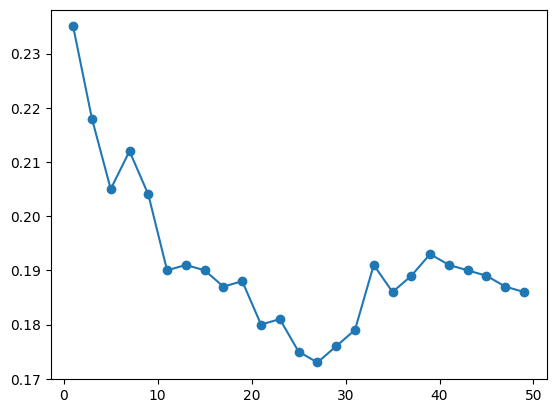

Investigating depths...


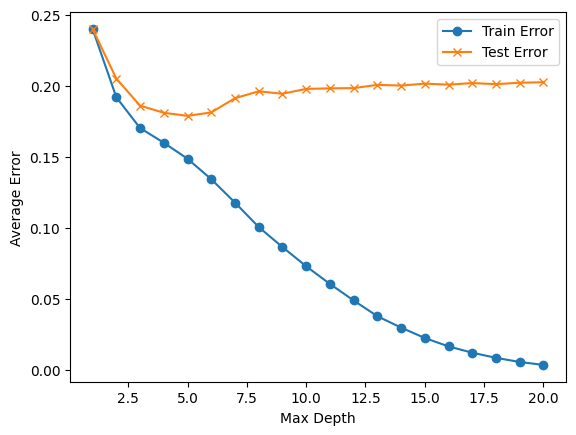

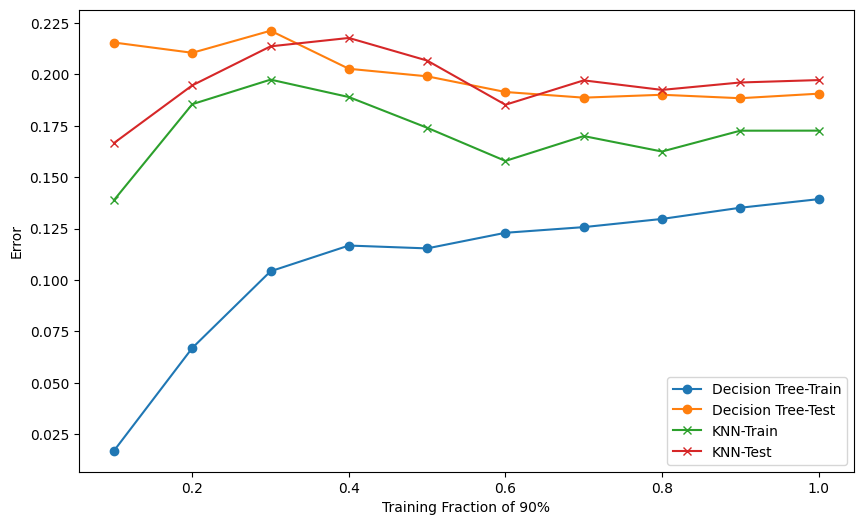

Done


In [ ]:

######################################################################
# main
######################################################################

def main():
    # load adult_subsample dataset with correct file path
    ### ========== TODO : START ========== ###
    data_file =  "/content/drive/My Drive/cm146/ps1/adult_subsample.csv"
    ### ========== TODO : END ========== ###


    data = load_data(data_file, header=1, predict_col=-1)

    X = data.X; Xnames = data.Xnames
    y = data.y; yname = data.yname
    n,d = X.shape  # n = number of examples, d =  number of features




    #========================================
    # part a: plot histograms of each feature
    print('Plotting...')
    plot_histograms (X, y, Xnames=Xnames, yname=yname)
    plt.show()



    ### ========== TODO : START ========== ###
    # part i: Preprocess X (e.g., normalize)
    # (try this after finishing the sections below)

    # X =  ?
    scaler = StandardScaler()
    X = scaler.fit_transform(X)

    ### ========== TODO : END ========== ###




    #========================================
    # train Majority Vote classifier on data
    print('Classifying using Majority Vote...')
    clf = MajorityVoteClassifier() # create MajorityVote classifier, which includes all model parameters
    clf.fit(X, y)                  # fit training data using the classifier
    y_pred = clf.predict(X)        # take the classifier and run it on the training data
    train_error = 1 - metrics.accuracy_score(y, y_pred, normalize=True)
    print('\t-- training error: %.3f' % train_error)





    ### ========== TODO : START ========== ###
    # part b: evaluate training error of Random classifier
    print('Classifying using Random...')
    clf = RandomClassifier ()
    clf.fit(X,y)
    y_pred = clf.predict(X)
    train_error = 1 - metrics.accuracy_score(y, y_pred)
    print('\t-- training error: %.3f' % train_error)
    ### ========== TODO : END ========== ###




    ### ========== TODO : START ========== ###
    # part c: evaluate training error of Decision Tree classifier
    print('Classifying using Decision Tree...')
    clf = DecisionTreeClassifier(criterion="entropy", random_state=0)
    clf.fit(X,y)
    y_pred = clf.predict(X)
    train_error = 1- metrics.accuracy_score(y, y_pred)
    print('\t-- training error: %.3f' % train_error)
    ### ========== TODO : END ========== ###




    ### ========== TODO : START ========== ###
    # part d: evaluate training error of k-Nearest Neighbors classifier
    # use k = 3, 5, 7 for n_neighbors
    print('Classifying using k-Nearest Neighbors...')
    for k in [3,5,7]:
      clf = KNeighborsClassifier(n_neighbors=k)
      clf.fit(X,y)
      y_pred= clf.predict(X)
      train_error = 1 - metrics.accuracy_score(y, y_pred, normalize=True)

    # print the error for each k
      print(f"Training error for KNN k = {k} : {train_error}")

    ### ========== TODO : END ========== ###




    ### ========== TODO : START ========== ###
    # part e: use cross-validation to compute average training and test error of classifiers
    print('Investigating various classifiers...')

    clfs = {
        "Majority Vote": MajorityVoteClassifier(),
        "Random": RandomClassifier(),
        "Decision Tree": DecisionTreeClassifier(random_state=0),
        "KNN": KNeighborsClassifier(n_neighbors=5)
    }

    for name, clf in clfs.items():
      print(f"Evaluating {name}...")
      train_error, test_error, f1_score = error(clf, X, y, ntrials=100, test_size=0.2)
      print(f"\t-- Training Error: {train_error:.3f}")
      print(f"\t-- Test Error: {test_error:.3f}")
      print(f"\t-- F1 Score: {f1_score:.3f}")
    ### ========== TODO : END ========== ###




    ### ========== TODO : START ========== ###
    # part f: use 10-fold cross-validation to find the best value of k for k-Nearest Neighbors classifier
    print('Finding the best k...')
    best_value = None
    best = 0
    values = [1,3,5,7,9,11,13,15,17,19,21,23,25,27,29,31,33,35,37,39,41,43,45,47,49]
    errors = []
    for k in values:
      clf = KNeighborsClassifier(n_neighbors=k)
      scores = cross_val_score(clf,X,y,cv=10)
      mean_score = scores.mean()
      errors.append(1-mean_score)

      if mean_score > best:
        best = mean_score
        best_value = k

    print(f"BEST K_VALUE: {best_value} ACCCURACY: {best}")
    plt.plot(values, errors, marker='o')
    plt.show()
    ### ========== TODO : END ========== ###




    ### ========== TODO : START ========== ###
    # part g: investigate decision tree classifier with various depths
    print('Investigating depths...')
    values = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20]
    train_errors, test_errors = [], []

    for value in values:
      clf = DecisionTreeClassifier(max_depth=value, criterion="entropy", random_state=0)


      train_error, test_error, f1_score = error(clf, X, y, ntrials=100, test_size=0.2)
      train_errors.append(train_error)
      test_errors.append(test_error)


    plt.plot(values, train_errors, label="Train Error", marker="o")
    plt.plot(values, test_errors, label="Test Error", marker="x")
    plt.legend()
    plt.xlabel("Max Depth")
    plt.ylabel("Average Error")
    plt.show()
    ### ========== TODO : END ========== ###





    ### ========== TODO : START ========== ###
    # part h: investigate decision tree and k-Nearest Neighbors classifier with various training set sizes
    # hint: use train_test_split (use random_state=0 for consistent results)
    best_depth=5
    best_k=15
    dt=DecisionTreeClassifier(max_depth=best_depth)
    knn = KNeighborsClassifier(n_neighbors=best_k)

    train_sizes = np.arange(0.1,1.1,0.1)

    train_errors_dt = []
    test_errors_dt = []
    train_errors_knn = []
    test_errors_knn = []

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=0)

    for size in train_sizes:
    # Subset of training data
        X_train_sub = X_train[:int(size * len(X_train))]
        y_train_sub = y_train[:int(size * len(y_train))]

    # Compute errors for Decision Tree
        train_error_dt, test_error_dt, _ = error(dt, X_train_sub, y_train_sub)
        train_errors_dt.append(train_error_dt)
        test_errors_dt.append(test_error_dt)

    # Compute errors for k-NN
        train_error_knn, test_error_knn, _ = error(knn, X_train_sub, y_train_sub)
        train_errors_knn.append(train_error_knn)
        test_errors_knn.append(test_error_knn)

# Plot the learning curves
    plt.figure(figsize=(10, 6))

# Decision Tree Learning Curve
    plt.plot(train_sizes, train_errors_dt, label="Decision Tree-Train", marker='o')
    plt.plot(train_sizes, test_errors_dt, label="Decision Tree-Test", marker='o')

# k-NN Learning Curve
    plt.plot(train_sizes, train_errors_knn, label="KNN-Train", marker='x')
    plt.plot(train_sizes, test_errors_knn, label="KNN-Test", marker='x')

# Labels and Title
    plt.xlabel("Training Fraction of 90%")
    plt.ylabel("Error")
    plt.legend()

    plt.show()
    ### ========== TODO : END ========== ###



    print('Done')


if __name__ == "__main__":
    main()
